# Sales Prediction for Big Mart Outlets

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

Try and Build Regression model using all the techniques of regression: Linear, Ridge, Lasso, Decision Tree and XGboost

## Imports and Preprocessing

In [1]:
# importing required data and libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# read the train data
df = pd.read_csv('trainbigmart.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [2]:
# check for the null values and explore shape as well
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [3]:
df.columns = [x.lower() for x in df.columns]
df.columns

Index(['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility',
       'item_type', 'item_mrp', 'outlet_identifier',
       'outlet_establishment_year', 'outlet_size', 'outlet_location_type',
       'outlet_type', 'item_outlet_sales'],
      dtype='object')

In [4]:
df.isna().sum()

item_identifier                 0
item_weight                  1463
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  2410
outlet_location_type            0
outlet_type                     0
item_outlet_sales               0
dtype: int64

There are only two variables with missing values – Item_Weight and Outlet_Size.

Since Item_Weight is a continuous variable, we can use either mean or median to impute the missing values. On the other hand, Outlet_Size is a categorical variable and hence we will replace the missing values by the mode of the column. You can try different methods to impute missing values as well.



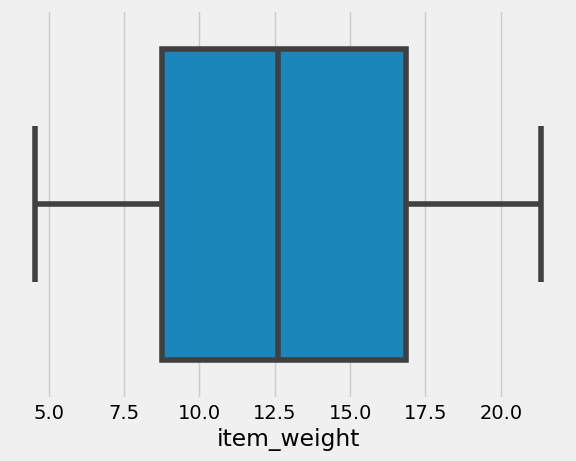

In [5]:
#create box plot on Item weight
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

sns.boxplot(x=df['item_weight'])
plt.show()

In [6]:
# impute missing values in item weight by mean
df['item_weight'] = df['item_weight'].fillna(df['item_weight'].mean())

In [7]:
# impute outlet size in training data by mode
df['outlet_size'] = df['outlet_size'].fillna(df['outlet_size'].mode()[0])

In [8]:
# check for the null values again
df.isna().sum()

item_identifier              0
item_weight                  0
item_fat_content             0
item_visibility              0
item_type                    0
item_mrp                     0
outlet_identifier            0
outlet_establishment_year    0
outlet_size                  0
outlet_location_type         0
outlet_type                  0
item_outlet_sales            0
dtype: int64

In [9]:
df.duplicated().sum() # checking duplicates

0

## Exploring categorical columns

In [10]:
cols = df.dtypes.to_frame()
cols[cols[0] == 'object'].index

Index(['item_identifier', 'item_fat_content', 'item_type', 'outlet_identifier',
       'outlet_size', 'outlet_location_type', 'outlet_type'],
      dtype='object')

In [11]:
cat_uq_df = df[['item_identifier', 'item_fat_content', 'item_type', 'outlet_identifier', 'outlet_size', 'outlet_location_type', 'outlet_type']].apply(lambda x: x.unique()).to_frame()
cat_uq_df

,0
item_identifier,"[FDA15, DRC01, FDN15, FDX07, NCD19, FDP36, FDO..."
item_fat_content,"[Low Fat, Regular, low fat, LF, reg]"
item_type,"[Dairy, Soft Drinks, Meat, Fruits and Vegetabl..."
outlet_identifier,"[OUT049, OUT018, OUT010, OUT013, OUT027, OUT04..."
outlet_size,"[Medium, High, Small]"
outlet_location_type,"[Tier 1, Tier 3, Tier 2]"
outlet_type,"[Supermarket Type1, Supermarket Type2, Grocery..."


In [12]:
# we need to convert low fat into Low Fat to mainatain consistency
# similarly, reg to Regular and LF to Low Fat

fat_conversion = {
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
}

df['item_fat_content'] = df['item_fat_content'].replace(fat_conversion)

In [13]:
df['item_fat_content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [14]:
df['item_identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: item_identifier, Length: 1559, dtype: int64

In [15]:
cat_df = df[['item_fat_content', 'item_type', 'outlet_identifier', 'outlet_size', 'outlet_location_type', 'outlet_type']]

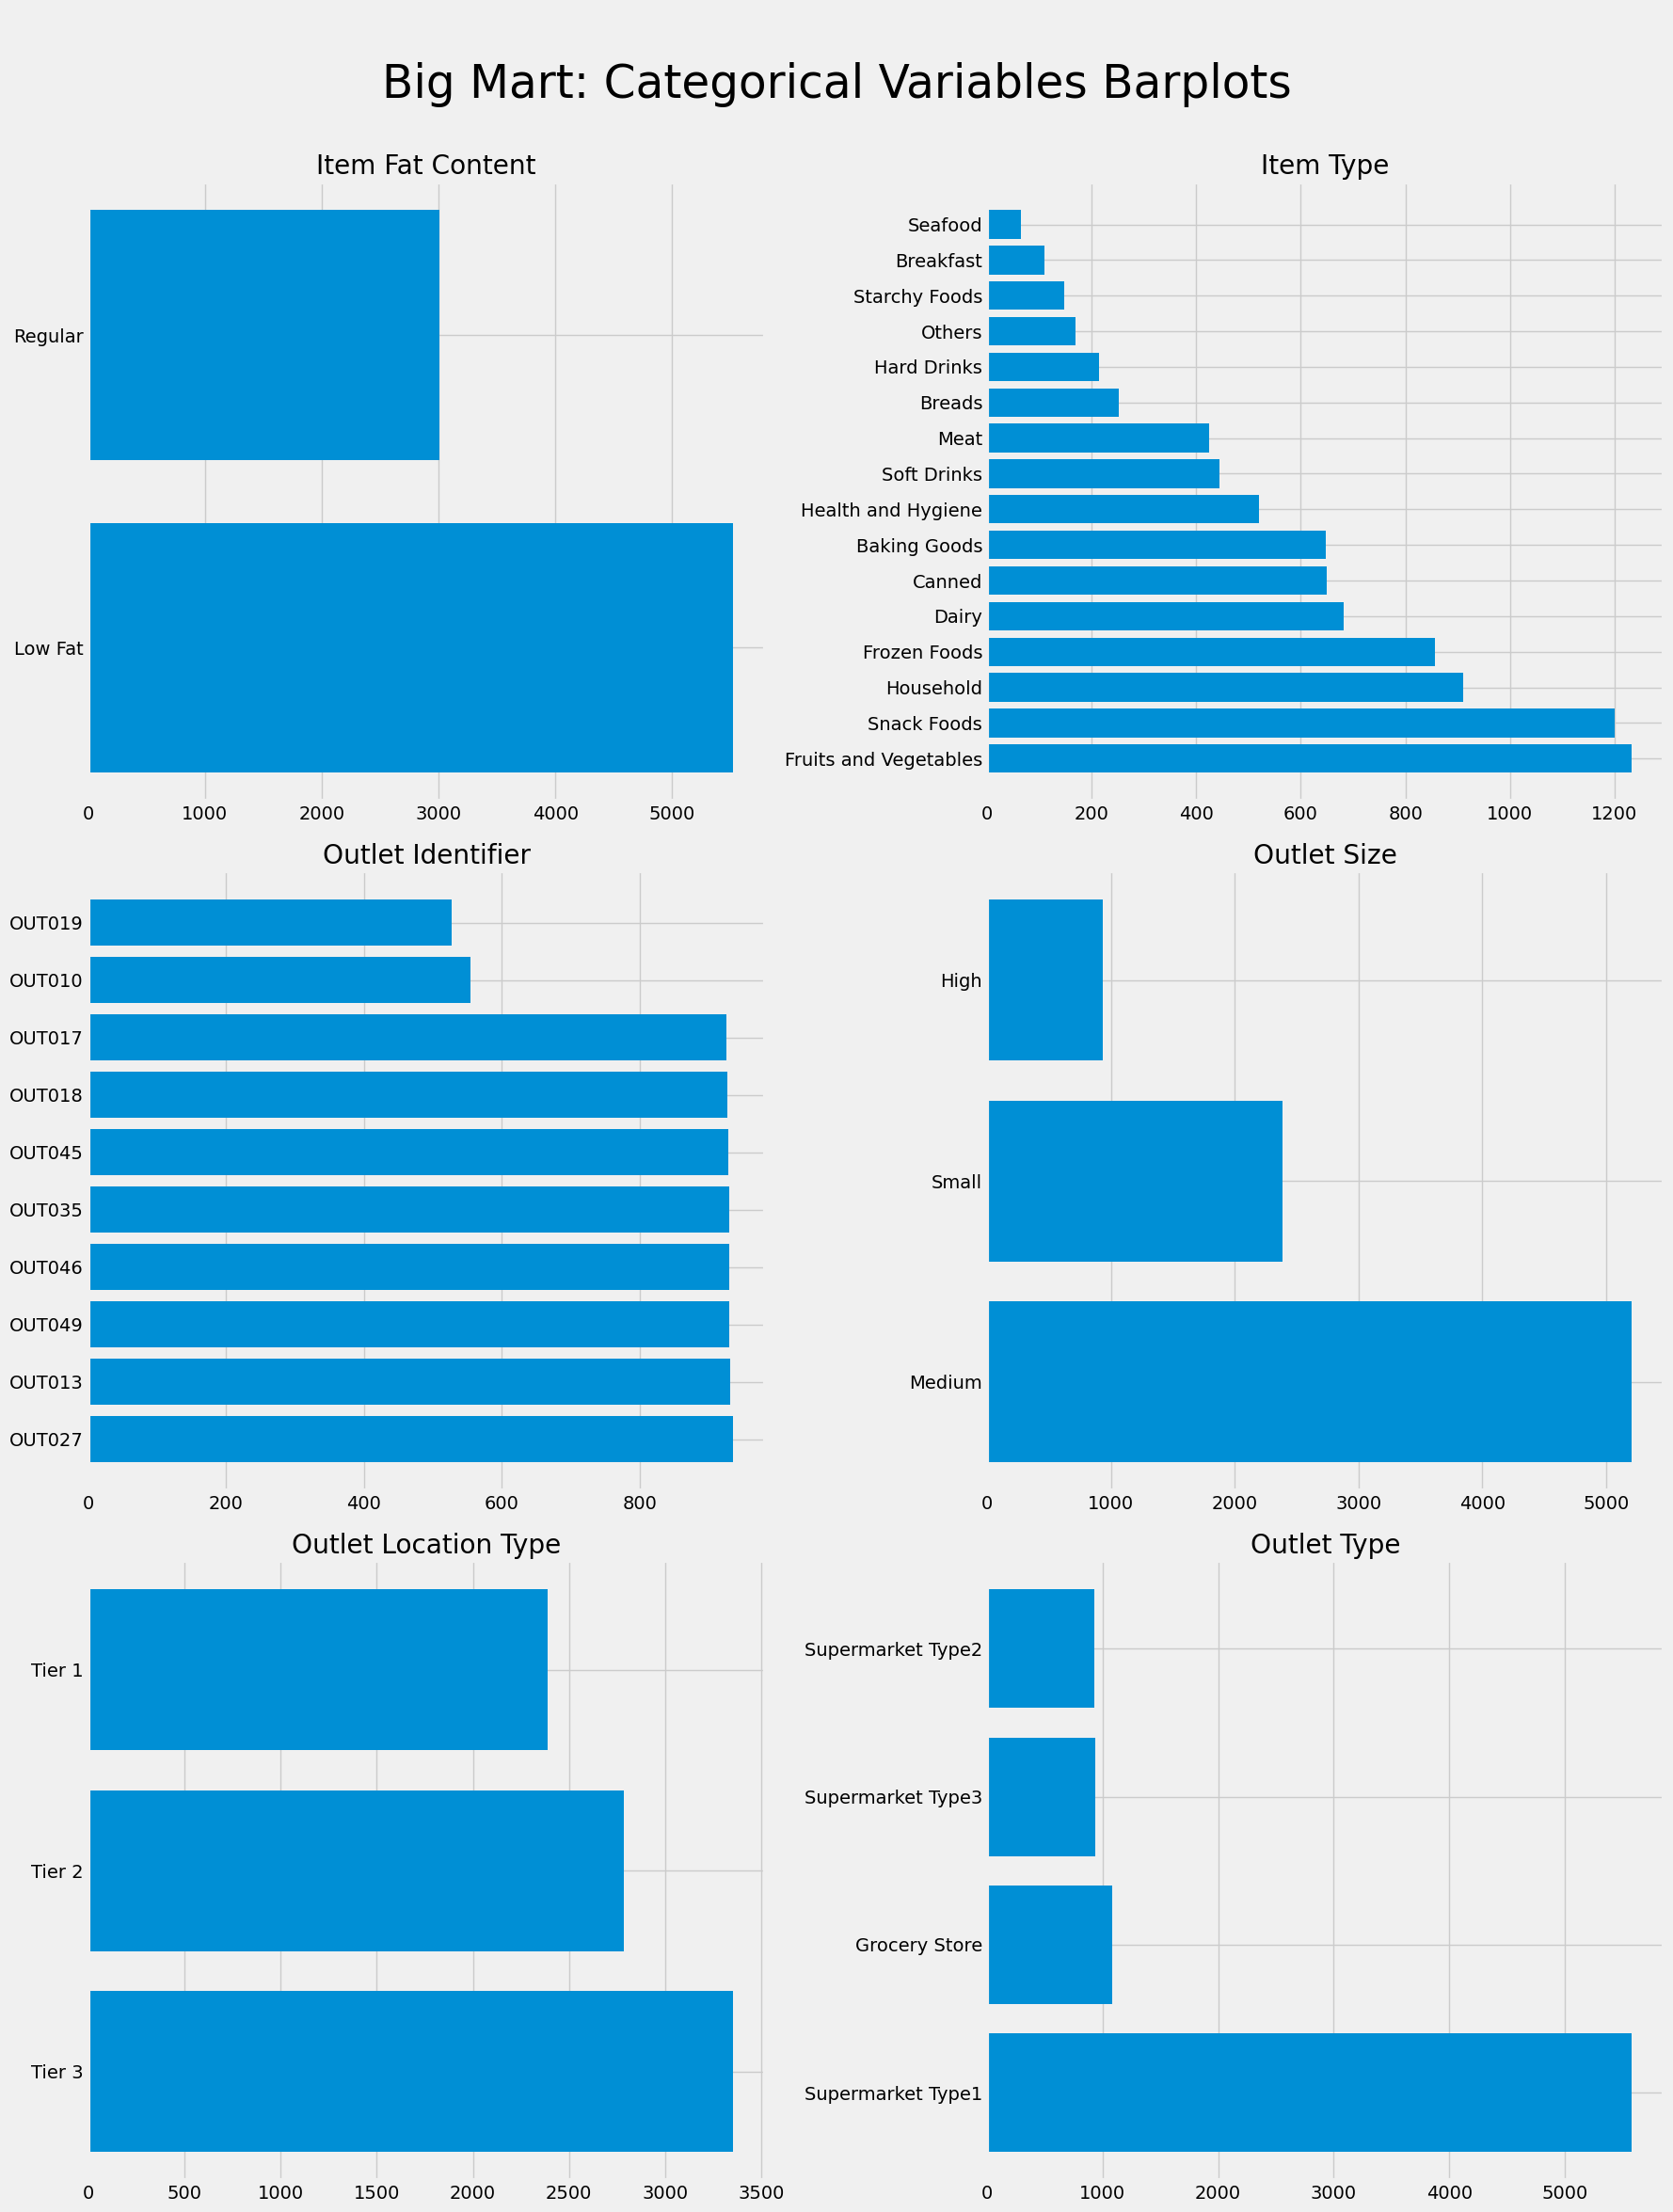

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))

col_index = 0
for i in range(3):
    for j in range(2):
        temp_df = cat_df.iloc[:, col_index].value_counts().to_frame().reset_index()
        ax[i, j].barh(temp_df.iloc[:, 0], temp_df.iloc[:, 1])
        ax[i, j].set_title(cat_df.columns[col_index].replace('_', ' ').title())
        col_index += 1
fig.suptitle('\nBig Mart: Categorical Variables Barplots\n', fontsize=35)
fig.tight_layout()
plt.show()
fig.savefig('Big Mart barplots.jpg')

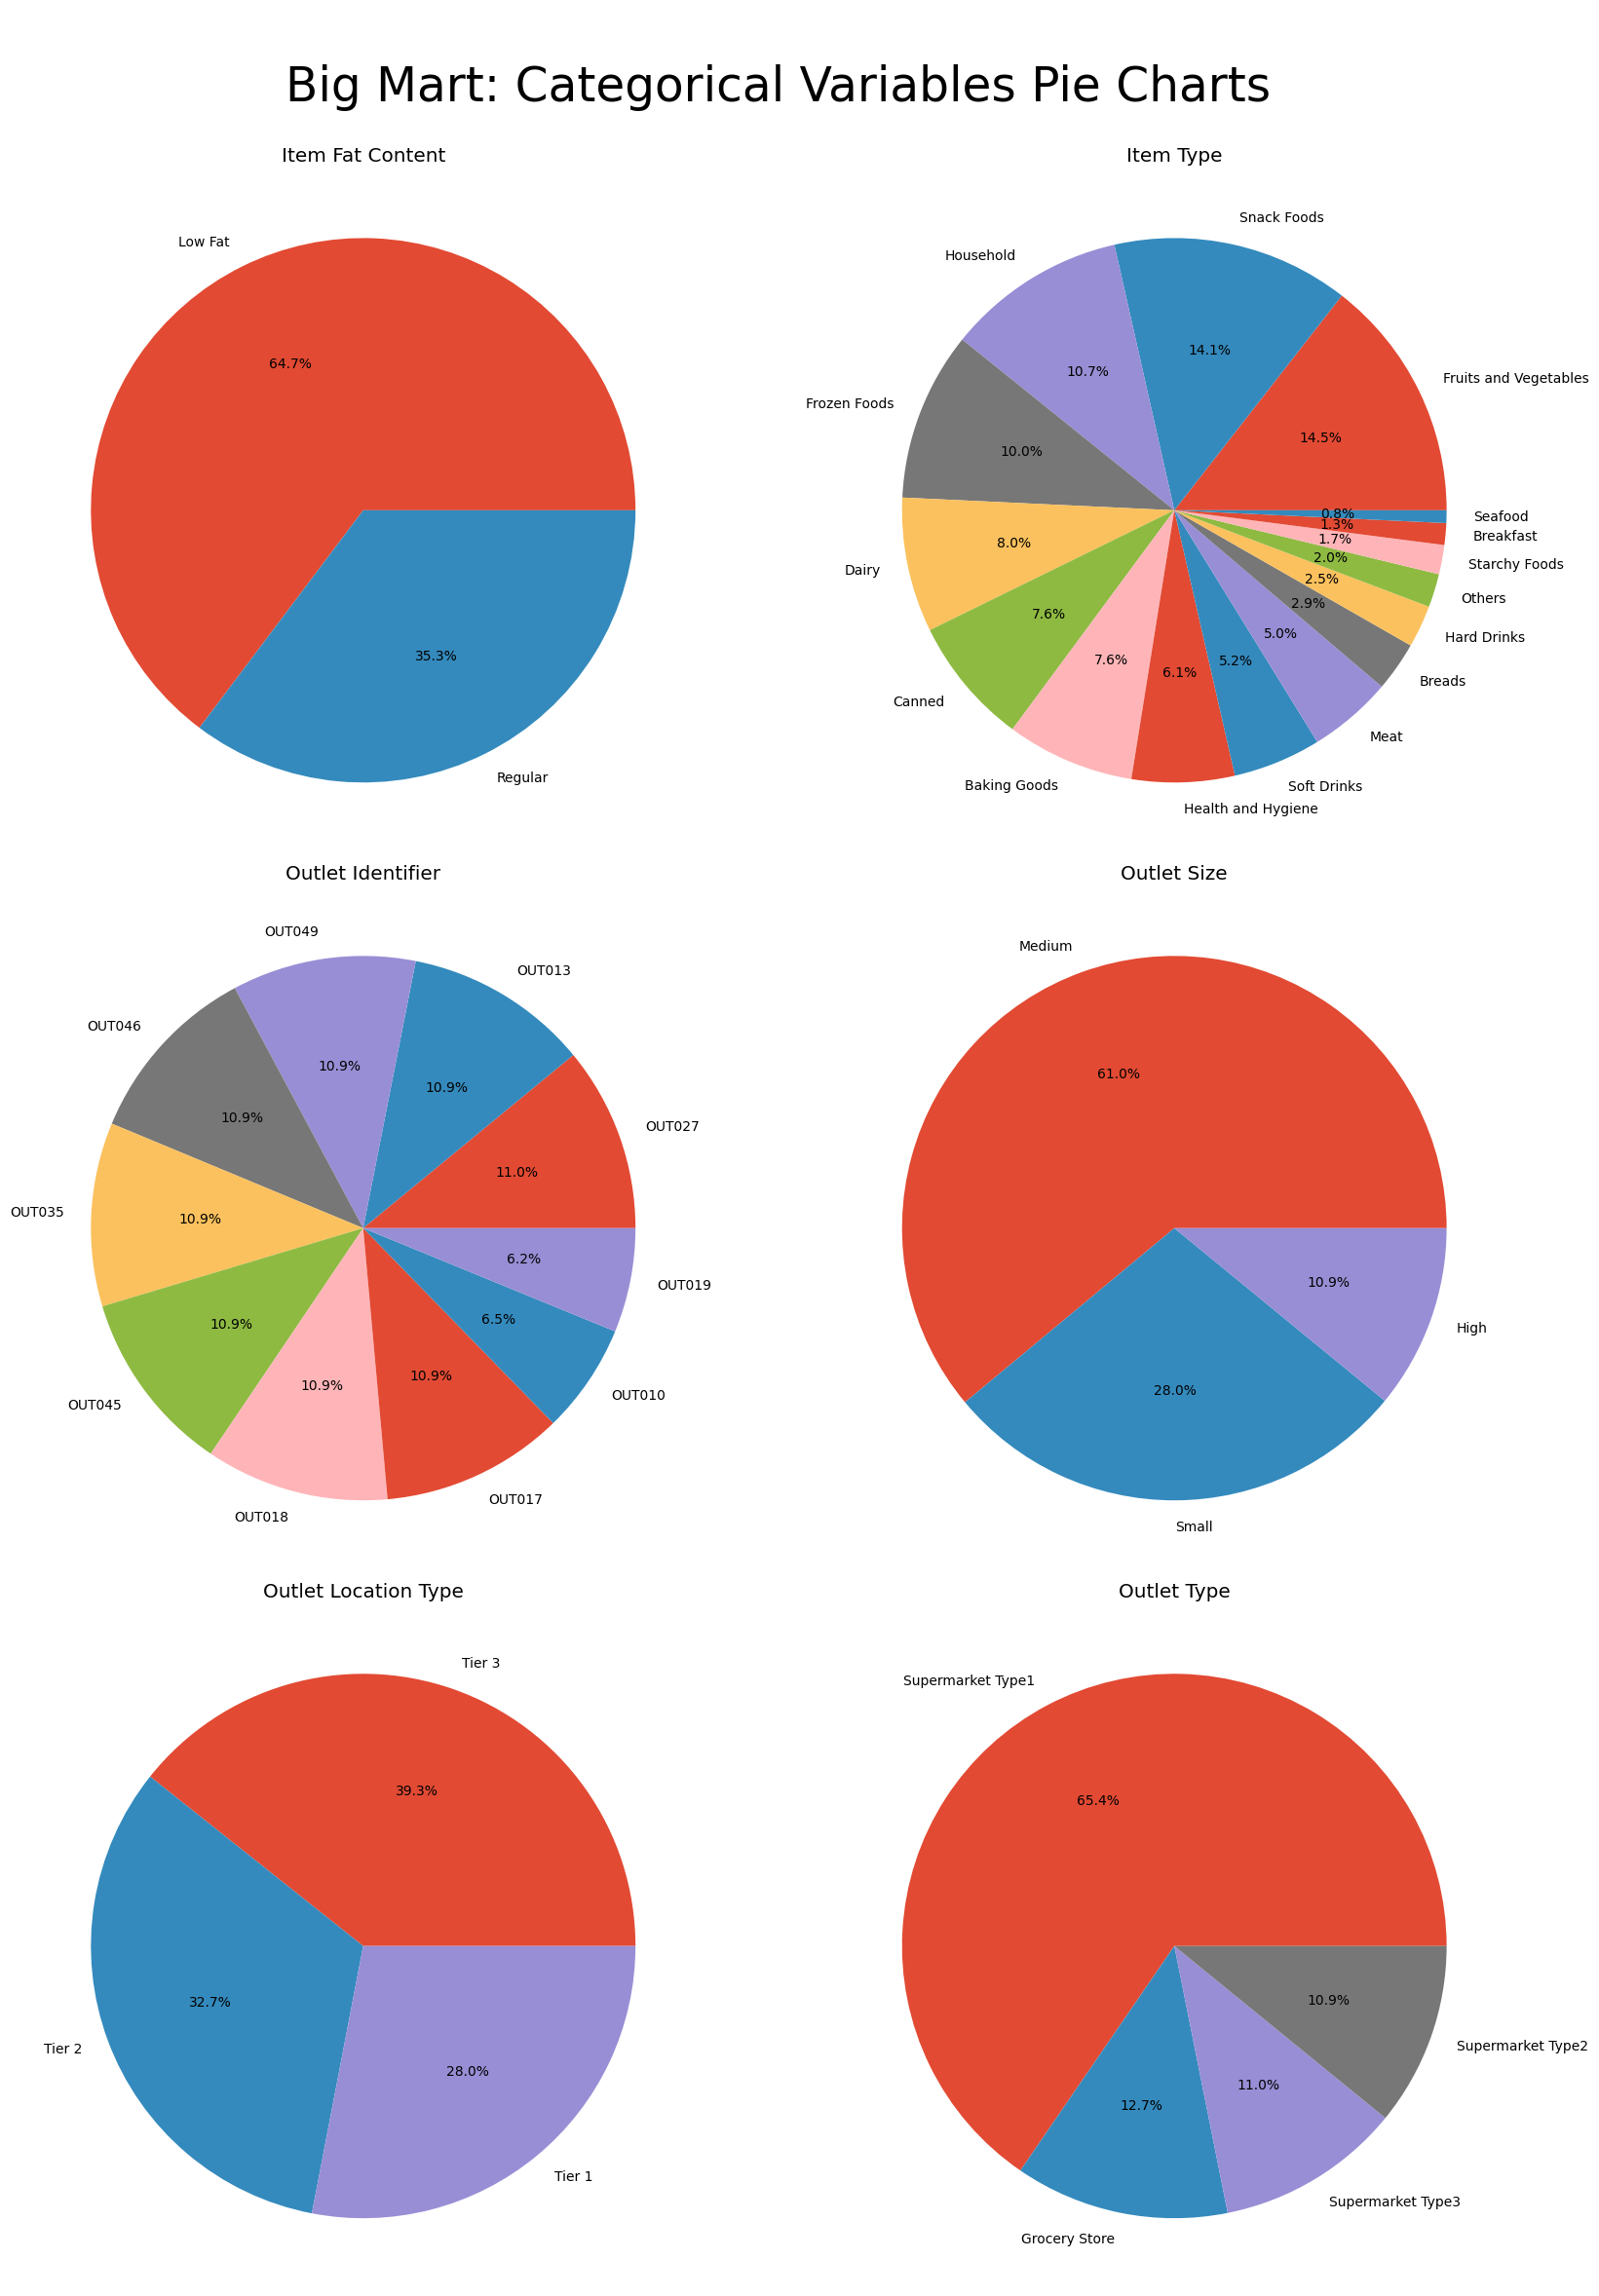

In [17]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))

col_index = 0
for i in range(3):
    for j in range(2):
        temp_df = cat_df.iloc[:, col_index].value_counts().to_frame().reset_index()
        ax[i, j].pie(temp_df.iloc[:, 1], labels=temp_df.iloc[:, 0], autopct='%.1f%%')
        ax[i, j].set_title(cat_df.columns[col_index].replace('_', ' ').title())
        col_index += 1
fig.suptitle('\nBig Mart: Categorical Variables Pie Charts\n', fontsize=35)
fig.tight_layout()
plt.show()
fig.savefig('Big Mart Pie Charts.jpg')

Encode the categorical variables

To check the categorical variables in the data, you can use the train_data.dtypes function. This will give you a list of the data types against each variable. For the BigMart sales data, we have the following categorical variable –

Item_Fat_Content

Item_Type,

Outlet_Identifier

Outlet_Size,

Outlet_Location_Type, and

Outlet_Type

In [18]:
cols = df.dtypes.to_frame()
cols[(cols[0] == 'int64') | (cols[0] == 'float64')].index

Index(['item_weight', 'item_visibility', 'item_mrp',
       'outlet_establishment_year', 'item_outlet_sales'],
      dtype='object')

In [19]:
cont_df = df[['item_weight', 'item_visibility', 'item_mrp', 'outlet_establishment_year', 'item_outlet_sales']]

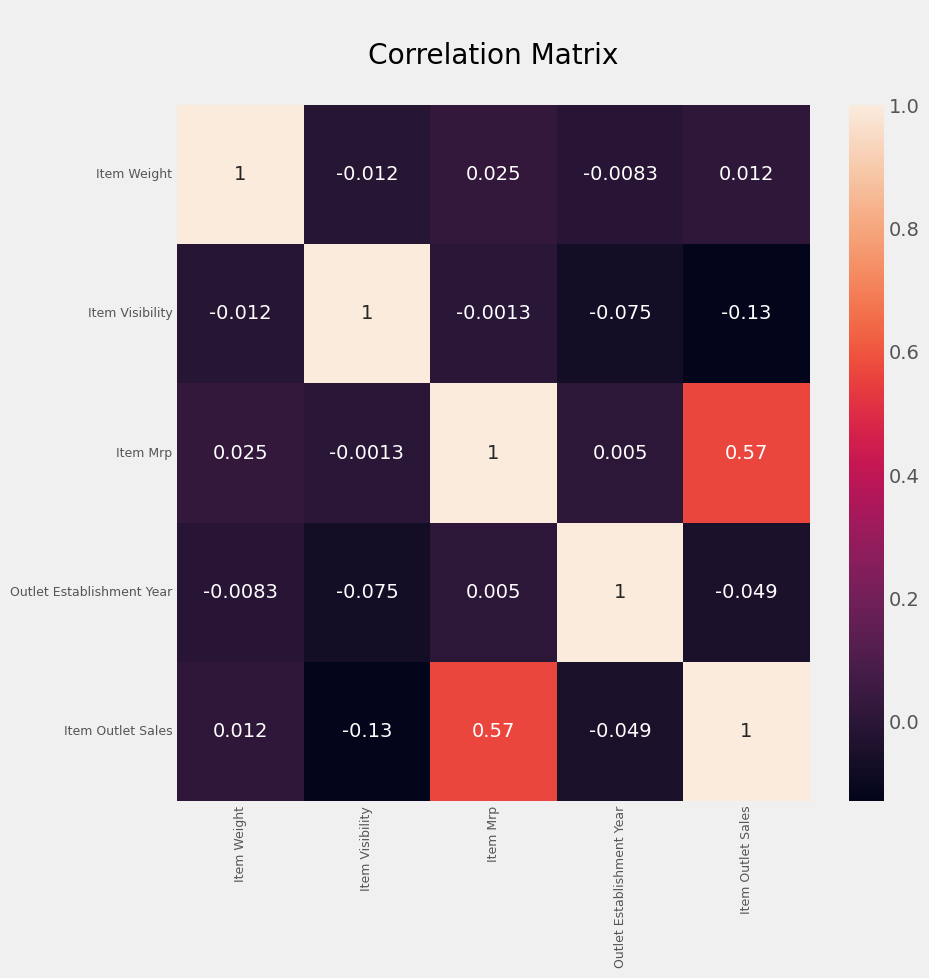

In [20]:
def parse_labels(label):
    return label.replace('_', ' ').title()


with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cont_df.corr(), annot=True)
    ax.set_xticklabels(map(parse_labels, cont_df.columns), fontsize=9)
    ax.set_yticklabels(map(parse_labels, cont_df.columns), fontsize=9)
    ax.set_title('\nCorrelation Matrix\n')
    fig.tight_layout()
    plt.show()
    fig.savefig('Correlation Martix.jpg')

A ***medium level*** of correlation is present between `Item Outlet Sales` and `Item MRP`.

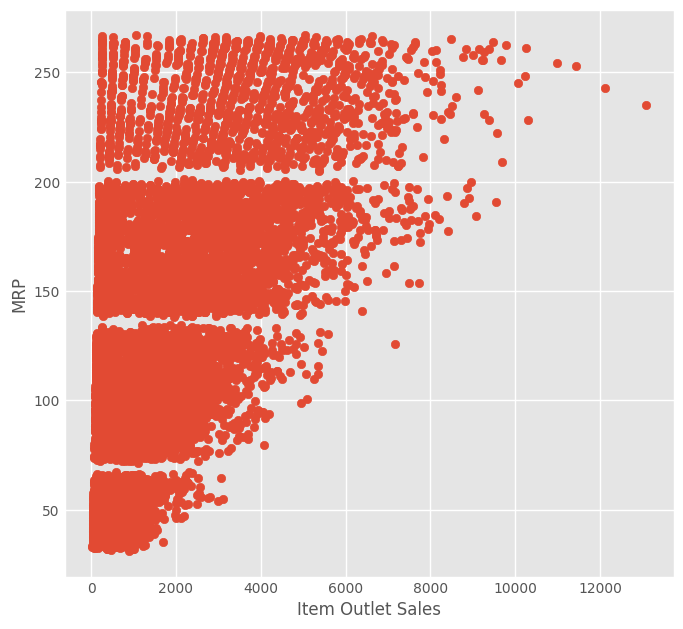

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(df['item_outlet_sales'], df['item_mrp'])
ax.set_xlabel('Item Outlet Sales')
ax.set_ylabel('MRP')
plt.show()
fig.savefig('outlet sales vs mrp correlation.jpg')

In [22]:
df['item_identifier'].nunique()

1559

## Encoding Data

In [23]:
from sklearn.preprocessing import LabelEncoder


categorical_cols = ['item_fat_content',
                    'item_type',
                    'outlet_identifier',
                    'outlet_size',
                    'outlet_location_type',
                    'outlet_type']
le = LabelEncoder()
# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

## Explore categorical columns after label encoding

In [24]:
df.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,FDA15,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,DRC01,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,FDN15,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,FDX07,19.20,1,0.000000,6,182.0950,0,1998,1,2,0,732.3800
4,NCD19,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


## One-Hot encoding for item identifier column.

In [25]:
item_id_encoded_df = pd.get_dummies(df['item_identifier'])

In [26]:
df.drop(columns=['item_identifier'], inplace=True)

In [27]:
new_df = pd.concat([item_id_encoded_df, df], axis=1)

In [28]:
new_df.head() # for tree based models

,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,0,0,0,0,0,0,0,0,0,0,...,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,0,0,0,0,0,0,0,0,1,0,...,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,0,0,0,0,0,0,0,0,0,0,...,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,0,0,0,0,0,0,0,0,0,0,...,1,0.000000,6,182.0950,0,1998,1,2,0,732.3800
4,0,0,0,0,0,0,0,0,0,0,...,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


## Creating copy of data for linear models and ANN.

In [29]:
lin_model_df = new_df.copy() # for linear models
ann_df = new_df.copy()

## Scale the data for linear model.

So far we have taken care of the missing values and the categorical (string) variables in the data. Next we will work with the continuous variables. Often the continuous variables in the data have different scales, for instance, a variable V1 can have a range from 0 to 1 while another variable can have a range from 0-1000.

Based on the type of model you are building, you will have to normalize the data in such a way that the range of all the variables is almost similar

In [30]:
# apply standard scaler on Item MRP column only
sc = StandardScaler()
lin_model_df['item_mrp'] = sc.fit_transform(lin_model_df[['item_mrp']])
lin_model_df.head()

,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,0,0,0,0,0,0,0,0,0,0,...,0,0.016047,4,1.747454,9,1999,1,0,1,3735.1380
1,0,0,0,0,0,0,0,0,1,0,...,1,0.019278,14,-1.489023,3,2009,1,2,2,443.4228
2,0,0,0,0,0,0,0,0,0,0,...,0,0.016760,10,0.010040,9,1999,1,0,1,2097.2700
3,0,0,0,0,0,0,0,0,0,0,...,1,0.000000,6,0.660050,0,1998,1,2,0,732.3800
4,0,0,0,0,0,0,0,0,0,0,...,0,0.000000,9,-1.399220,1,1987,0,2,1,994.7052


## Model Building

Now that we are done with the basic pre-processing steps, we can go ahead and build simple machine learning models over this data. We will try two models here – Linear Regression to predict the sales.

To compare the performance of the models, we will create a validation set (or test set). Here I have randomly split the data into two parts using the train_test_split() function, such that the validation set holds 25% of the data points while the train set has 75%

### Utility functions

In [35]:
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error


def get_evaluation_scores(model, X_train, X_test, y_train, y_test):
    '''
    takes a model and prints evaluation scores on train and test set.
    parameters
        model: ML model to evaluate
    returns
        None
    '''
    y_pred_train = model.predict(X_train)
    print('Train')
    print("R-Squared:", r2_score(y_train, y_pred_train))
    print("RMSE:", mean_squared_error(y_train, y_pred_train) ** 0.5)

    y_pred_test = model.predict(X_test)
    print('\nTest')
    print("R-Squared:", r2_score(y_test, y_pred_test))
    print("RMSE:", mean_squared_error(y_test, y_pred_test) ** 0.5)

In [36]:
def get_best_model(model, params, X_train, y_train):
    '''
    takes a model and its hyperparameters and tune it.

    parameters
        model: ML model to tune
        params: parameter(s) used

    return
        best model (tuned)
    '''
    grid_search = GridSearchCV(model, params, scoring='r2', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print()
    return grid_search.best_estimator_

### Data splitting for linear models.

In [31]:
# separate the independent and target variable
X1, y1 = lin_model_df.iloc[:, :-1].values, lin_model_df.iloc[:, -1].values

# randomly split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1) # by default `test_size=0.25`

# shape of train and test splits
print(X_train1.shape, X_test1.shape)

(6392, 1569) (2131, 1569)


### Model 1: Multiple Linear Regression

In [32]:
lr_model = LinearRegression()
lr_model.fit(X_train1, y_train1)

LinearRegression()

In [37]:
get_evaluation_scores(lr_model, X_train1, X_test1, y_train1, y_test1)

Train
R-Squared: 0.6263855922547976
RMSE: 1044.528119122925

Test
R-Squared: 0.3172705688465455
RMSE: 1403.4976560898735


`Linear Regression` model **overfitted** the data.

### Model 2: Lasso Regression

In [44]:
params = {
    'alpha': [0.5, 1.0, 1.5, 2.0]
}

lasso_model = get_best_model(Lasso(), params, X_train1, y_train1)

Best parameters: {'alpha': 1.5}
Best score: 0.5143858295568986



In [45]:
get_evaluation_scores(lasso_model, X_train1, X_test1, y_train1, y_test1)

Train
R-Squared: 0.5167494327260311
RMSE: 1187.9400226071423

Test
R-Squared: 0.489431599955541
RMSE: 1213.7083653691743


### Model 3: Ridge Regression

In [46]:
params = {
    'alpha': range(70, 95)
}

ridge_model = get_best_model(Ridge(), params, X_train1, y_train1)

Best parameters: {'alpha': 94}
Best score: 0.512252492201547



In [47]:
get_evaluation_scores(ridge_model, X_train1, X_test1, y_train1, y_test1)

Train
R-Squared: 0.5235866403594018
RMSE: 1179.5063785131317

Test
R-Squared: 0.48839469717751016
RMSE: 1214.9401878434103


### Data splitting for tree based models.

In [48]:
# separate the independent and target variable
X2, y2 = new_df.iloc[:, :-1].values, new_df.iloc[:, -1].values

# randomly split the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2) # by default `test_size=0.25`

# shape of train and test splits
print(X_train2.shape, X_test2.shape)

(6392, 1569) (2131, 1569)


### Model 4: Random Forest

In [61]:
params = {
    'n_estimators': [10, 12, 15],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 3, 4]
}

rf_model = get_best_model(RandomForestRegressor(), params, X_train2, y_train2)

Best parameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 12}
Best score: 0.5882439892473966



In [62]:
get_evaluation_scores(rf_model, X_train2, X_test2, y_train2, y_test2)

Train
R-Squared: 0.6208726073505353
RMSE: 1047.2043600536142

Test
R-Squared: 0.6074014263742697
RMSE: 1079.7113952375023


### Model 5: XG Boost

In [71]:
params = {
    'n_estimators': [13, 14, 15],
    'max_depth': [2, 3, 4],
    'lambda': [3, 4, 5],
    'gamma': [3, 4, 5]
}

xg_model = get_best_model(XGBRegressor(), params, X_train2, y_train2)

Best parameters: {'gamma': 4, 'lambda': 4, 'max_depth': 3, 'n_estimators': 14}
Best score: 0.5998942271288424



In [72]:
get_evaluation_scores(xg_model, X_train2, X_test2, y_train2, y_test2)

Train
R-Squared: 0.6146912123668656
MAE: 750.8676105945992
MSE: 1125595.1501714021

Test
R-Squared: 0.5973108718367928
MAE: 746.1254594920523
MSE: 1160741.3204889465


### Model 6: Light GBM

In [70]:
params = {
    'n_estimators': [100, 120, 150],
    'max_depth': [2, 3],
    'num_leaves': [3, 4],
    'min_data_in_leaf': [90, 100, 150]
}

gbm_model = get_best_model(LGBMRegressor(), params, X_train2, y_train2)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 10
[LightGBM] [Info] Start training from score 2194.070051
Best parameters: {'max_depth': 2, 'min_data_in_leaf': 100, 'n_estimators': 120, 'num_leaves': 3}
Best score: 0.6022604169204575



In [68]:
get_evaluation_scores(gbm_model, X_train2, X_test2, y_train2, y_test2)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Train
R-Squared: 0.6115598933700674
MAE: 759.4835289891492
MSE: 1156679.4773127898
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100

Test
R-Squared: 0.5999267001500723
MAE: 734.7783130836698
MSE: 1085000.05830942


### Data splitting for ANN.

In [51]:
# separate the independent and target variable
X3, y3 = ann_df.iloc[:, :-1].values, ann_df.iloc[:, -1].values

# randomly split the data
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3) # by default `test_size=0.25`

# shape of train and test splits
print(X_train3.shape, X_test3.shape)

(6392, 1569) (2131, 1569)


### Scaling data for ANN.

In [63]:
ann_sc = StandardScaler()
X_train3 = ann_sc.fit_transform(X_train3)
X_test3 = ann_sc.transform(X_test3)

### Model 7: ANN

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


ann = Sequential([
    Dense(4096, activation='relu', kernel_initializer='he_normal'),
    Dense(2184, activation='relu', kernel_initializer='he_normal'),
    Dense(2184, activation='relu', kernel_initializer='he_normal'),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='linear')
])

In [88]:
ann.compile(loss='mean_squared_error', optimizer=Adam(1e-2), metrics=['mean_absolute_error'])

In [90]:
history = ann.fit(X_train3, y_train3, epochs=100, batch_size=64, validation_data=(X_test3, y_test3))

Epoch 1/100
100/100 [==============================] - 53s 532ms/step - loss: 2124092.2500 - mean_absolute_error: 1061.9705 - val_loss: 2404829.5000 - val_mean_absolute_error: 1097.0167
Epoch 2/100
100/100 [==============================] - 48s 482ms/step - loss: 1618662.3750 - mean_absolute_error: 912.9616 - val_loss: 2272686.5000 - val_mean_absolute_error: 1096.3113
Epoch 3/100
100/100 [==============================] - 52s 519ms/step - loss: 1276709.0000 - mean_absolute_error: 806.6285 - val_loss: 2014454.8750 - val_mean_absolute_error: 1012.1517
Epoch 4/100
100/100 [==============================] - 52s 517ms/step - loss: 1182688.1250 - mean_absolute_error: 761.6633 - val_loss: 2074525.5000 - val_mean_absolute_error: 1013.4133
Epoch 5/100
100/100 [==============================] - 48s 481ms/step - loss: 1078937.6250 - mean_absolute_error: 727.4627 - val_loss: 2043141.8750 - val_mean_absolute_error: 1036.7017
Epoch 6/100
100/100 [==============================] - 51s 508ms/step - lo